## Effectiveness of the proposal on interpretation

In [1]:
import torch
import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.gray()

from pathlib import Path
from torch.utils.data import DataLoader
sys.path.append("../src")

from util.seed import worker_init_fn, seed
from util.load_data import load_data
from util.dataset import DATASET
from models.character_encoder import CharacterEncoder

seed()

<Figure size 432x288 with 0 Axes>

In [2]:
beta = 8.0
encode_dim = 10
character_encoder_version = 0
args = argparse.Namespace(**{"beta": beta, "encode_dim": encode_dim})

In [3]:
checkpoint_path = list(
    Path(
        f"../logs/character_encoder/BetaVAE(beta={beta})/encode_dim{encode_dim}/version_{character_encoder_version}"
    ).glob("*.ckpt")
)[0]
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model_checkpoint = {
    key.replace("model.", ""): value 
    for key, value in checkpoint["state_dict"].items()
}

In [4]:
character_encoder = CharacterEncoder["BetaVAE"](args)
character_encoder.load_state_dict(model_checkpoint)
character_encoder = character_encoder.eval()

In [5]:
path = {
    "ja_chars": "../data/pickle/ja_chars.pkl",
    "font": "../data/font/ipag.ttf"
}
data = DATASET["ja_chars"](path)
data_loader = DataLoader(
    data,
    batch_size=1,
    shuffle=False,
    num_workers=1, 
    worker_init_fn=worker_init_fn
)

In [6]:
char2embedding = {
    label[0]: character_encoder(data)["z"].detach().numpy()
    for data, label in data_loader
}

In [7]:
perturbations = np.arange(-2.0, 2.1, 0.5)
sub_char_thread_list = ["縄", "綱"]
dim_id = 0

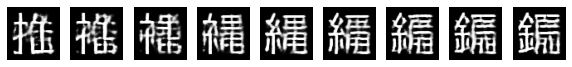

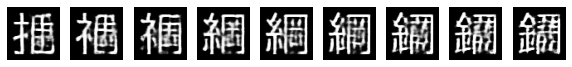

In [8]:
for char in sub_char_thread_list:
    fig = plt.figure(figsize=(10, 2))
    for i, perturbation in enumerate(perturbations, 1):
        d_input = torch.from_numpy(char2embedding[char].copy())
        d_input[0, dim_id] += torch.tensor(perturbation)

        decode = character_encoder.decoder(d_input)[0, 0].detach().numpy()

        ax = fig.add_subplot(1, len(perturbations), i)
        ax.imshow(decode)
        ax.set_axis_off()
    plt.show()

## Nearest Neighbors

In [9]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [10]:
embeddings = np.array(
    list(char2embedding.values())
).squeeze(1)
characters = list(char2embedding.keys())

In [11]:
knn = NearestNeighbors(n_neighbors=5)
knn.fit(embeddings)

NearestNeighbors()

In [12]:
target_character = "Query"
sub_char_thread = "綱"
dim_id = 0
perturbation = 2

In [13]:
query_embedding = char2embedding[sub_char_thread].copy()
query_embedding[0, dim_id] += perturbation

embeddings = np.vstack([embeddings, query_embedding])
characters.append(target_character)

In [14]:
dist, indices = knn.kneighbors(embeddings)

In [15]:
neighbors = [
    (characters[idx], dist[characters.index(target_character)][i])
    for i, idx in enumerate(indices[characters.index(target_character)])
]
neighbors = pd.DataFrame(
    neighbors, columns=["Neighbouring character", "Euclidean distance"]
)

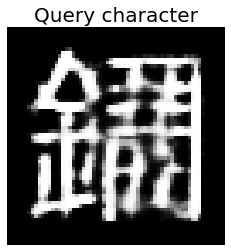

In [16]:
query_character = character_encoder.decoder(torch.from_numpy(query_embedding)).detach().numpy()[0, 0]
plt.title("Query character", fontsize=20)
plt.axis("off")
plt.imshow(query_character)

In [17]:
# Top five characters near the query character
neighbors

,Neighbouring character,Euclidean distance
0,鋼,1.984526
1,綱,2.000000
2,繻,2.180717
3,鑷,2.187140
4,網,2.207712
